<a href="https://colab.research.google.com/github/Bone-Age-Maisha/Bone_imp_1/blob/main/learning_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd


In [ ]:
import pandas as pd
train_dir = '/content/drive/MyDrive/hand_atlas/image'
df = pd.read_csv('/content/drive/MyDrive/hand_atlas/data.csv')

In [ ]:
df['boneage'].max()

228.1

In [ ]:
df['boneage'].min()

0.3616

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

IndexError: ignored

In [ ]:
X_train = []
y_age = []
y_gender = []

#df = pd.read_csv('/raid/chenchao/code/BoneAge/BoneAge/data/Training.csv')
a = df.values
m = a.shape[0]

path = train_dir
k = 0
print ('Loading data set...')
k=1
for i in os.listdir(path):
  #print(i)
  if(i=="3131.jpg" or i=="4520.jpg" or i=="3187.jpg"):
    continue
  y_age.append(df.boneage[df.id == int(i[:-4])].tolist()[0])
  y_gender.append(df.gender[df.id == int(i[:-4])].tolist()[0])
  #print(i)
  img_path = path + "/"+i
  img = cv2.imread(img_path)
  #print(img.shape)
  #print (img_path)
  img = cv2.imread(img_path)
    #print (img_path)
    #if(img is not None):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(300,300))
  x = np.asarray(img, dtype=np.uint8)
  X_train.append(x)
  k=k+1

Loading data set...


In [ ]:
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing import image
import os

def softlabel(label,num_class):
    softlabel=np.zeros((len(label),num_class))
    ratio = 1.0/50
    for i in range(len(label)):
        for j in range(num_class):
            softlabel[i,j]=1.0 - ratio*np.abs(j-label[i])
    softlabel = np.maximum(softlabel,0)
    return softlabel


def ShowAttentionV1(model,image_path):
    file_list = os.listdir(image_path)
    file_list.sort()
    for filename in file_list:
        print (filename)
        filepath=image_path+filename
        image=load_image(filepath)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        layer=K.function([model.layers[0].input],[model.layers[196].output])
        FeatureMap=layer([image,gender])[0]
        print (FeatureMap.shape)
        FeatureMap = np.squeeze(FeatureMap, axis=0)
        FeatureMap = np.abs(FeatureMap)
        heatmap = np.mean(FeatureMap,axis=2)
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def GAPAttention(model,weights,image_path):
    file_list = os.listdir(train_dir)
    file_list.sort()
    for filename in file_list:
        filepath=image_path+filename
        print (filepath)
        image=load_image(filepath)
        print("gpa")
        print(image.shape)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        print("ok")
        layer=K.function([model.layers[0].input],[model.layers[1].get_output_at(-1),model.layers[-1].output])
        print("ok_1")
        GAP,prediction=layer([image])
        print("ok_2")
        GAP=np.squeeze(GAP,axis=0)
        print("ok_3")
        print (GAP.shape)
        print("ok_4")
        index = np.argmax(prediction)
        print("ok_5")
        print (index)
       # weight = weights[:,index]
        weight =np.mean(weights[:,index-5:index+5],axis=1)
        heatmap = np.zeros((GAP.shape[0],GAP.shape[1]))
        for k in range(GAP.shape[2]):
            heatmap = heatmap + weight[k]*GAP[:,:,k]
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    cv2.imwrite('/content/heat'+filename,heatmap)
    cv2.imwrite('/content/attention'+filename,AttentionImg)


def load_image(path):
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img,(300,300))
    print(img.shape)
    x = np.asarray(img, dtype=np.float32)
   # img = image.load_img(path, target_size=(448, 448))
   # print (img.shape)
   # x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def TestMAE(model,test_data,test_label,test_gender):
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[3].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    predictions = np.array(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE
    
def DataAugment(x_train):
    x_train_Aug = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        for j in range(3):
            img = x_train[i,:,:,j]
            img = RandomMask(img)
            img = RandomMask(img)
            if np.random.random()>-1:
                x_train_Aug[i,:,:,j]=img 
            else:
                x_train_Aug[i,:,:,j]=x_train[i,:,:,j]
    return x_train_Aug


def RandomMask(img):
    m,n=img.shape
    m=int(m/6)
    n=int(n/6)
    i,j = np.random.randint(0,6,2)
    img[i*m:(i+1)*m,j*n:(j+1)*n]=np.random.random()
    return img

In [ ]:
y = np.asarray(y_age)
gender = np.asarray(y_gender)
x=np.asarray(X_train, dtype=np.float32)
x=x/255
gender =2*( gender-0.5)
x_final = []
y_final = []
gender_final = []

# Shuffle images and split into train, validation and test sets
#random_no = np.random.choice(x.shape[0], size=x.shape[0], replace=False)
random_no = np.arange(x.shape[0])
#print(random_no)
np.random.seed(42)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
print (y_final[:50])
print (gender_final[:50])
k = 50 # Decides split count
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]

## 
#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)
y_trains = softlabel(y_train,240)
y_valids = softlabel(y_valid,240)
y_tests = softlabel(y_test,240)
print (y_train)


print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

[ 24.2  135.7  173.4   77.13 212.8  157.5   47.87  94.82 140.2   70.29
 123.5  127.4   96.   170.2  174.5   81.86  65.59 141.2  164.9   22.29
  90.12  57.24 169.6  145.9  101.1   70.32 102.6  197.5  141.8  176.5
 162.   161.4  159.5  180.6   99.78 173.6  159.7  101.6  135.5  177.6
 212.9  204.6  221.3   13.15 128.8  191.    72.36  91.86 158.4  222.8 ]
[-1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.]
[  7.693 217.    159.3   ... 190.1    84.59  174.1  ]
x_train shape:(1286, 300, 300, 3)
y_train shape:(1286,)
gender_train shape:(1286,)
x_valid shape:(50, 300, 300, 3)
y_valid shape:(50,)
gender_valid shape:(50,)
x_test shape:(50, 300, 300, 3)
y_test shape:(50,)


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda, Multiply
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras

batch_size = 16
epochs = 30


In [ ]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

DataGen = ImageDataGenerator(rotation_range=20,width_shift_range=0.15,height_shift_range=0.15,zoom_range=0.2,horizontal_flip=True)

In [ ]:
age1=[]
for i in range(114):
    age1.append(i)
age2=[]
for i in range (114,228):
    age2.append(i)
age=[]
for i in range (1):
    age.append(age1)
    age.append(age2)
age=np.asarray(age)
aget=[]
for i in range(1286):
    aget.append(age)
aget=np.asarray(aget)
print(aget.shape)

(1286, 2, 114)


In [ ]:
agev=[]
for i in range(50):
  agev.append(age)
agev=np.asarray(agev)
agev.shape

(50, 2, 114)

In [ ]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,114),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(228,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_inception.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 228)
0 input1
1 inception_v3
2 conv2d_189
3 max_pooling2d_9
4 input2
5 flatten_2
6 dense_4
7 concatenate_5
8 dense_5
9 input3
10 dense_6
11 flatten_3
12 multiply_1
13 dense_7
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   21802784    ['input1[0][0]']                 
                                2048)                                                             
                                                                                                  
 conv2d_1

Epoch 1/40


KeyboardInterrupt: ignored

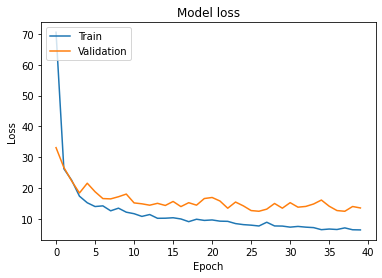

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,114),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(228,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_densnet.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 228)
0 input1
1 densenet201
2 conv2d_395
3 max_pooling2d_16
4 input2
5 flatten_8
6 dense_13
7 concatenate_8
8 dense_14
9 input3
10 dense_15
11 flatten_9
12 multiply_4
13 dense_16
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, None, None,   18321984    ['input1[0][0]']                 
                                1920)                                                             
                                                                                                  
 conv

Epoch 1/40
322/322 [==============================] - 87s 192ms/step - loss: 87.8864 - MAE: 87.8864 - val_loss: 47.8169 - val_MAE: 47.8169
Epoch 2/40
322/322 [==============================] - 51s 158ms/step - loss: 27.4790 - MAE: 27.4790 - val_loss: 29.6434 - val_MAE: 29.6434
Epoch 3/40
322/322 [==============================] - 51s 157ms/step - loss: 19.9467 - MAE: 19.9467 - val_loss: 21.4519 - val_MAE: 21.4519
Epoch 4/40
322/322 [==============================] - 51s 158ms/step - loss: 18.2061 - MAE: 18.2061 - val_loss: 24.0744 - val_MAE: 24.0744
Epoch 5/40
322/322 [==============================] - 51s 158ms/step - loss: 14.7013 - MAE: 14.7013 - val_loss: 17.6353 - val_MAE: 17.6353
Epoch 6/40
322/322 [==============================] - 51s 158ms/step - loss: 13.7493 - MAE: 13.7493 - val_loss: 23.6998 - val_MAE: 23.6998
Epoch 7/40
322/322 [==============================] - 51s 158ms/step - loss: 13.6840 - MAE: 13.6840 - val_loss: 18.2164 - val_MAE: 18.2164
Epoch 8/40
322/322 [=======

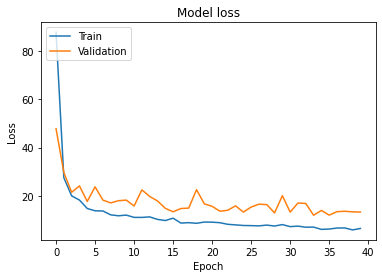

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,114),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(228,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invres.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=40)
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
#history=model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 228)
0 input1
1 inception_resnet_v2
2 conv2d_599
3 max_pooling2d_21
4 input2
5 flatten_10
6 dense_17
7 concatenate_9
8 dense_18
9 input3
10 dense_19
11 flatten_11
12 multiply_5
13 dense_20
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, None, None,   54336736   ['input1[0][0]']                 
 l)                             1536)                                                             
                                                                                              

Epoch 1/40
322/322 [==============================] - 88s 215ms/step - loss: 64.4070 - MAE: 64.4070 - val_loss: 1113.3740 - val_MAE: 1113.3740
Epoch 2/40
322/322 [==============================] - 64s 197ms/step - loss: 27.0570 - MAE: 27.0570 - val_loss: 42.4018 - val_MAE: 42.4018
Epoch 3/40
322/322 [==============================] - 64s 198ms/step - loss: 19.5035 - MAE: 19.5035 - val_loss: 132.2687 - val_MAE: 132.2687
Epoch 4/40
322/322 [==============================] - 64s 199ms/step - loss: 16.1300 - MAE: 16.1300 - val_loss: 18.0157 - val_MAE: 18.0157
Epoch 5/40
322/322 [==============================] - 64s 198ms/step - loss: 14.3333 - MAE: 14.3333 - val_loss: 18.2466 - val_MAE: 18.2466
Epoch 6/40
322/322 [==============================] - 64s 198ms/step - loss: 13.7322 - MAE: 13.7322 - val_loss: 17.9353 - val_MAE: 17.9353
Epoch 7/40
322/322 [==============================] - 63s 197ms/step - loss: 12.9951 - MAE: 12.9951 - val_loss: 17.6895 - val_MAE: 17.6895
Epoch 8/40
322/322 [=

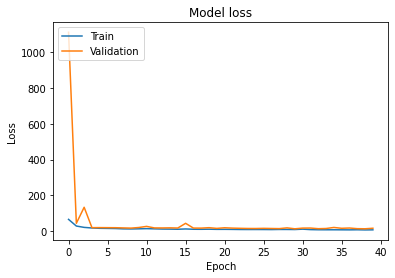

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Augmentation

In [ ]:
DataGen.fit(x_train)

In [ ]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,120),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(240,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_augincep.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
model.fit_generator(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train,aget],y_train,batch_size=4,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

In [ ]:
def Generator(x_train,gender_train,y_train,age,batch_size):
    loopcount = len(y_train)//batch_size
    i=0
    while (True):
        if i>loopcount:
            i=0
        # i=np.random.randint(0,loopcount)
        x_train_batch = x_train[i*batch_size:(i+1)*batch_size,:,:,:]
        #DataGen.fit(x_train_batch)
        gender_train_batch = gender_train[i*batch_size:(i+1)*batch_size]
        y_train_batch = y_train[i*batch_size:(i+1)*batch_size]
        age_train_batch = age[i*batch_size:(i+1)*batch_size]
        inputs = [x_train_batch,gender_train_batch,age_train_batch]
        target = y_train_batch
        yield (inputs ,target)
        i = i+1

In [ ]:
import tensorflow as tf


base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
input_age = Input(shape=(2,114),dtype='float32',name='input3')
data_augmentation = tf.keras.layers.RandomFlip("horizontal")(input)
data_augmentation = tf.keras.layers.RandomRotation((-0.2, 0.2))(data_augmentation)
output = base_model(data_augmentation)
gender_embedding=Dense(32)(input_gender)
#age_embedding=Dense(240)(input_age)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
f = Dense(512, activation='relu')(f)
x =Dense(228,activation='linear')(f)
y=Flatten()(input_age)
print(y.shape)
f = keras.layers.Multiply()([x,y])
predictions=Dense(1)(f)

model = Model(inputs=[input,input_gender,input_age], outputs=predictions)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary()


checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_augincep.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=20)
#model.fit(DataGen.flow([x_train,gender_train,aget],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=40,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit(Generator(x_train,gender_train,y_train,aget,batch_size),batch_size=batch_size,epochs=20,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test,agev], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 228)
0 input1
1 random_flip
2 random_rotation
3 inception_v3
4 conv2d_94
5 max_pooling2d_4
6 input2
7 flatten
8 dense
9 concatenate_2
10 dense_1
11 input3
12 dense_2
13 flatten_1
14 multiply
15 dense_3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 300, 300, 3)  0           ['input1[0][0]']                 
                                                                                                  
 random_rotation (RandomRotatio  (None, 300, 300, 3)  0          ['random_flip[0][0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
    248/Unknown - 3584s 14s/step - loss: 57.8841 - MAE: 57.8841